In [1]:
cd ../src

C:\Users\Sam\smore\src


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import nibabel as nib
import numpy as np
import os
import torch
import time

from models.edsr import *
from pathlib import Path
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils.fba import *
from utils.plot import *
from utils.test_loader import TestSet
from utils.preprocess import open_interp_rotate, reorient
from utils.rotate import rotate_vol_2D, inv_rotate_vols_2D

In [16]:
IN_FNAME = Path("../SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled.nii")
OUT_FNAME = Path("../pretrain_notrain.nii")
WEIGHT_DIR = Path("../weights")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [17]:
#################### LOAD AND PROCESS DATA ####################

res = open_interp_rotate(img_fpath=IN_FNAME, n_rots=2)
imgs_rot, affine, header, pads, acq_res, k, blur_k, lr_axis = res
orig_shape = imgs_rot[0].shape
orig_min = imgs_rot[0].min()

========== PREPROCESSING IMAGE ==========
Interpolating through-plane...
	Elapsed time: 3.9563s
Creating 2 rotations...
	Elapsed time: 0.1887s


In [18]:
from utils.plot import *

In [19]:
tmp = nib.load(IN_FNAME).get_fdata()

In [20]:
tmp.shape

(256, 256, 45)

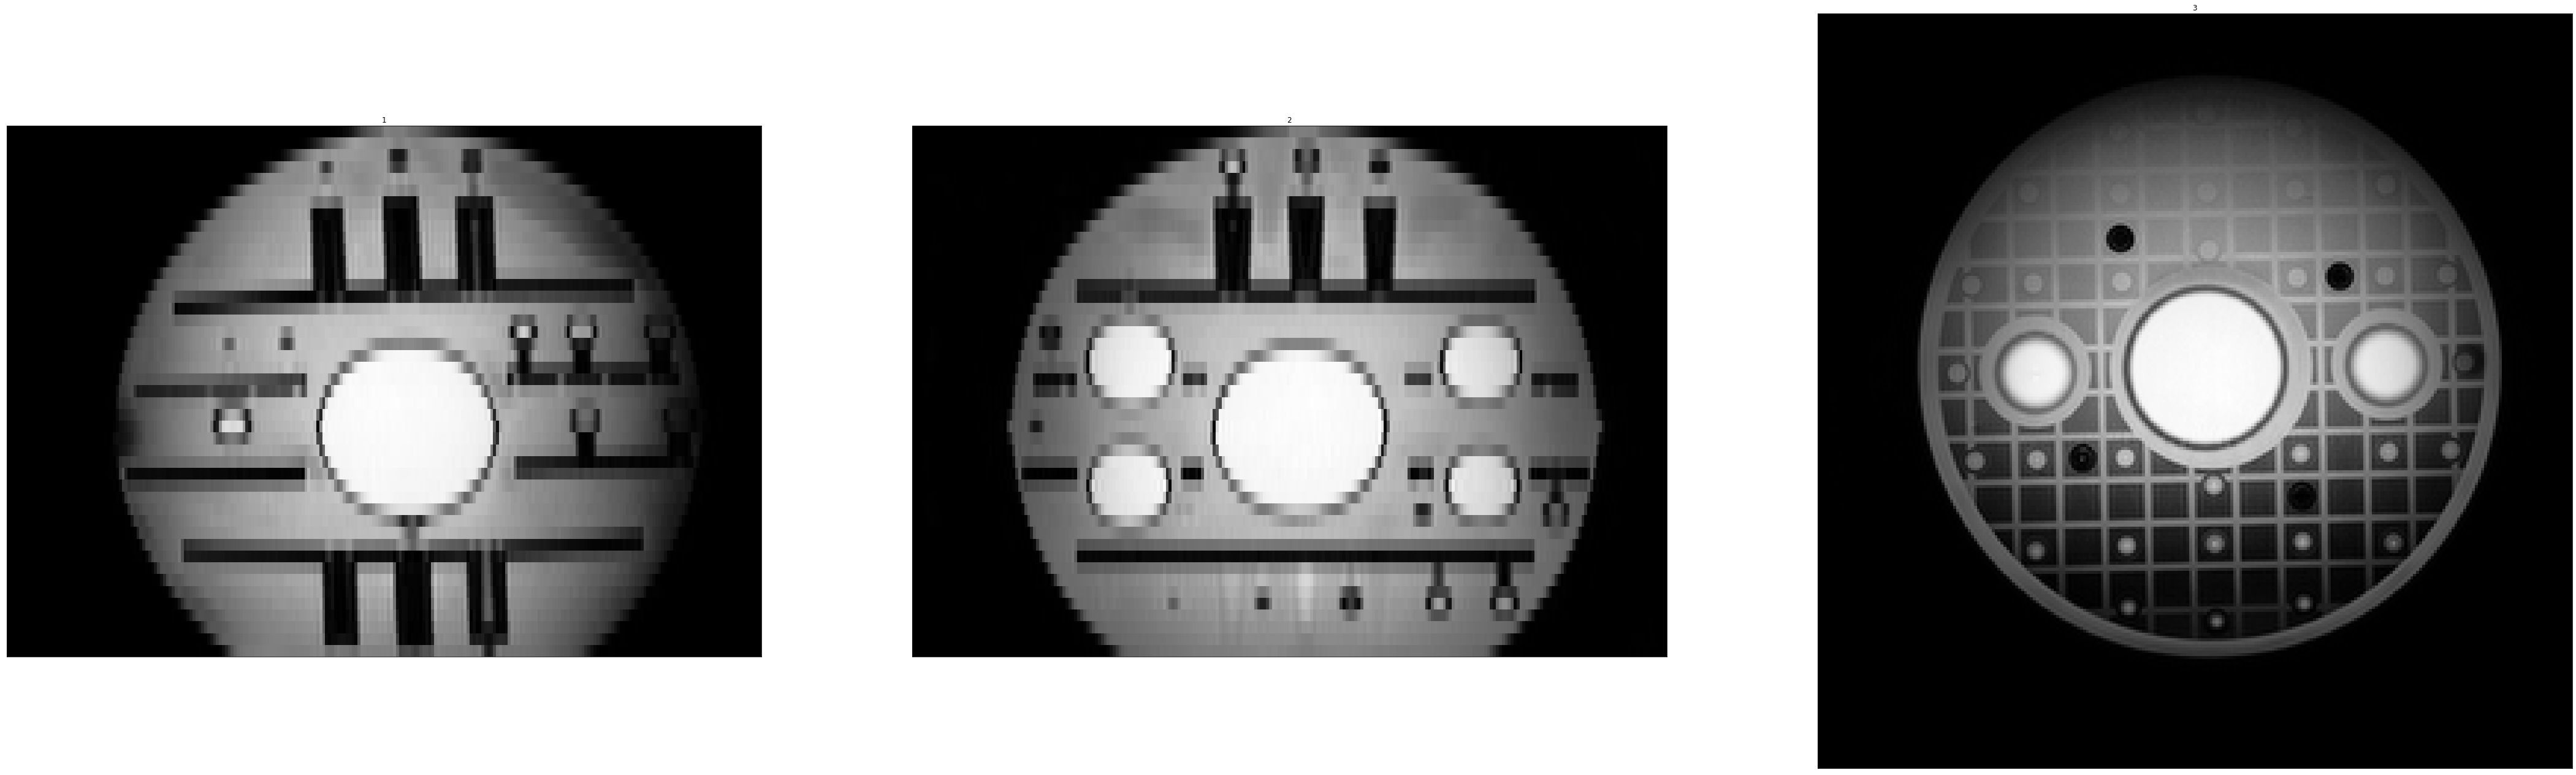

In [22]:
center_vol_plot(tmp, (256, 256, 180))

In [23]:
imgs_rot[0].shape

(256, 256, 180)

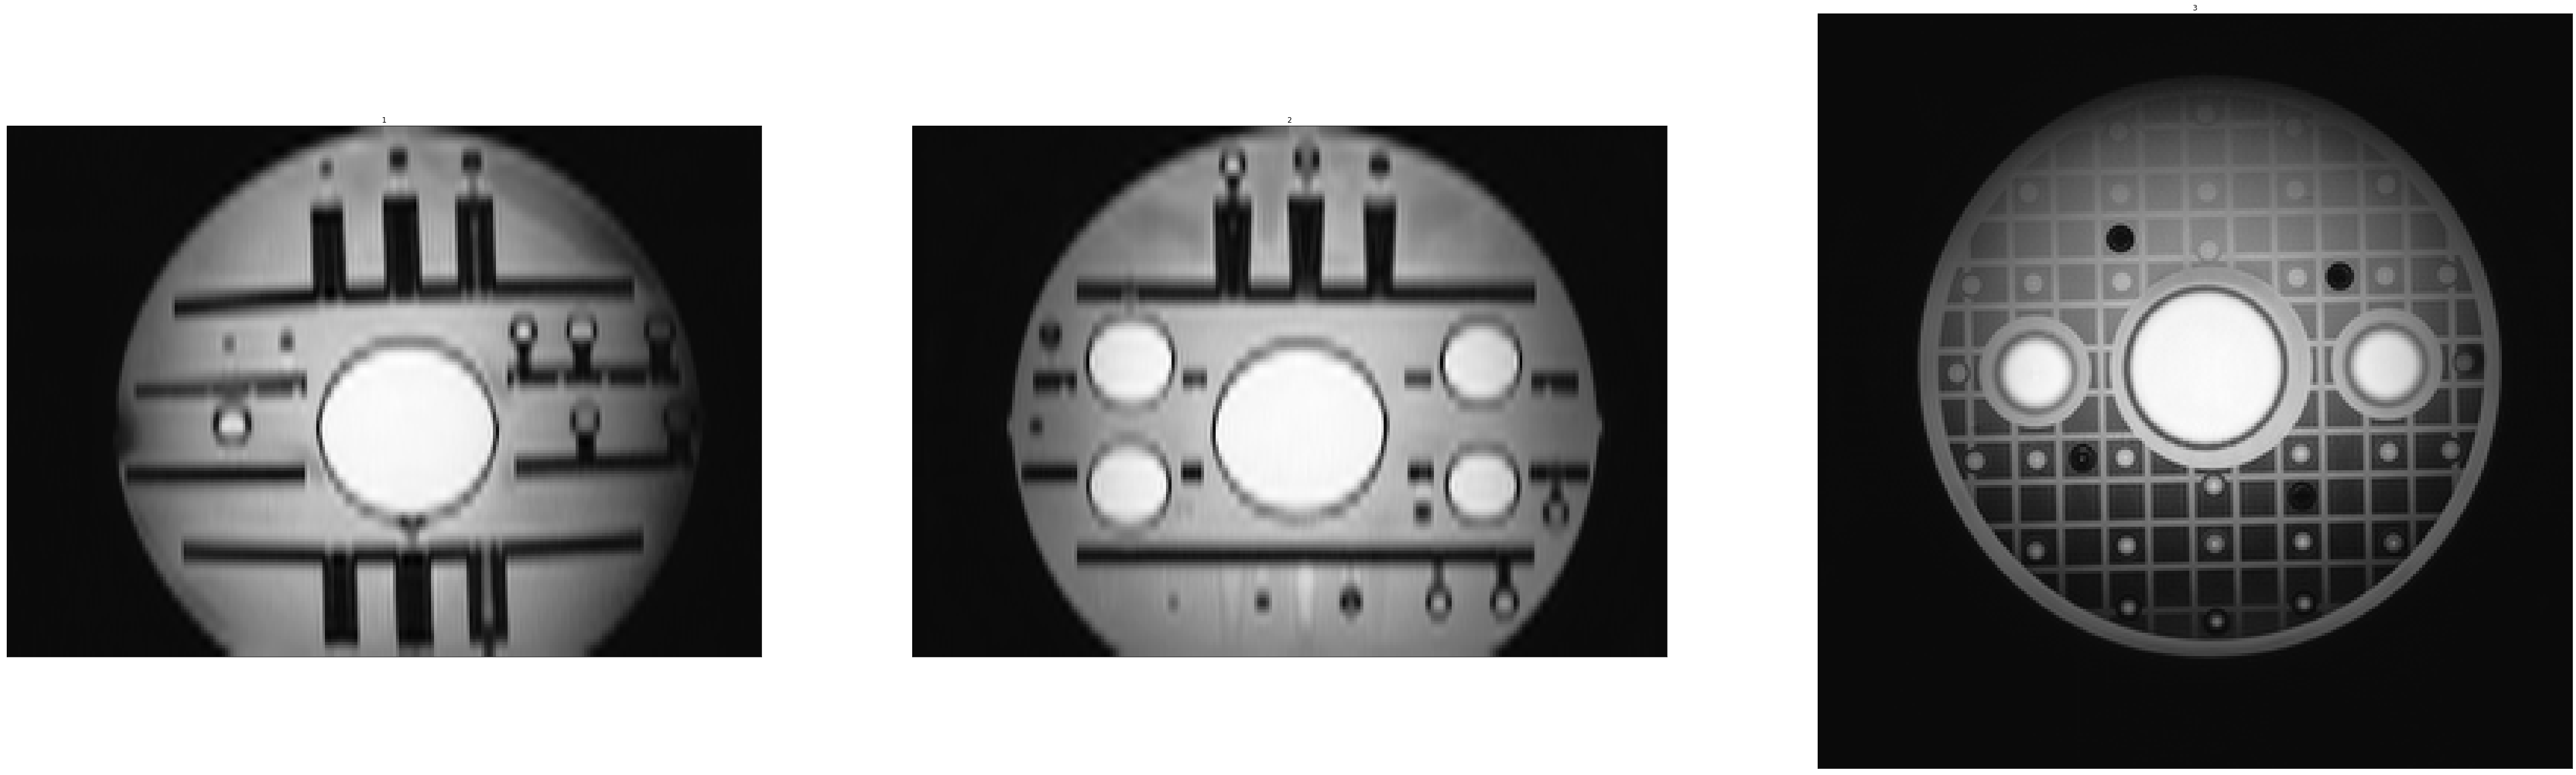

In [24]:
center_vol_plot(imgs_rot[0])

In [9]:
model_preds = []

In [10]:
WEIGHT_FNAME = "channel_flip_{}_MRI_EDSR.h5"

In [11]:
AA_WEIGHT_PATH = WEIGHT_DIR / WEIGHT_FNAME.format('AA')
aa_checkpoint = torch.load(AA_WEIGHT_PATH)
aa_model = EDSR(
    n_channels=1,
    kernel_size=kernel_size,
    n_resblocks=n_resblocks,
    filters=filters,
    padding_mode='zeros',
    min_clip=min_clip,
).cuda()
aa_model.load_state_dict(aa_checkpoint['model'])

SR_WEIGHT_PATH = WEIGHT_DIR / WEIGHT_FNAME.format('SR')
sr_checkpoint = torch.load(SR_WEIGHT_PATH)
sr_model = EDSR(
    n_channels=1,
    kernel_size=kernel_size,
    n_resblocks=n_resblocks,
    filters=filters,
    padding_mode='zeros',
    min_clip=min_clip,
).cuda()
sr_model.load_state_dict(sr_checkpoint['model'])

<All keys matched successfully>

In [ ]:
st = time.time()

for img_xyz in imgs_xyz:
    # apply AA
    img_xzy = img_xyz.transpose(0, 2, 1)
    img_aa_xzy = apply_model_volume_slices(
        vol=img_xzy,
        model=aa_model,
        batch_size=BATCH_SIZE,
    )

    # apply SR
    img_aa_yzx = img_aa_xzy.transpose(2, 1, 0)
    img_sr_yzx = apply_model_volume_slices(
        vol=img_aa_yzx,
        model=sr_model,
        batch_size=BATCH_SIZE,
    )

    img_sr_xyz = img_sr_yzx.transpose(2, 0, 1)

    # inv normalize
#     img_sr_xyz = inv_normalize(img_sr_xyz, *inv_normalize_params)
    model_preds.append(img_sr_xyz.copy())

# Rotate preds back
model_preds = inv_get_n_rots(model_preds, max_angle=90, n_cores=N_CORES)

en = time.time()
print("Time for prediction : {:.4f}s".format(en-st))

 79%|███████████████████████████████████████████████████████████████▏                | 202/256 [01:33<00:25,  2.14it/s]

In [ ]:
# Fourier Burst Accumulation
st = time.time()

# Only do FBA if there are multiple volumes on which to apply
if len(model_preds) > 1:
    print("Applying FBA...")
    final_out = fba(model_preds, p=0)
else:
    print("Only one rotation; skipping FBA.")
    final_out = model_preds[0]

# Re-center mean
# final_out /= final_out.mean()
# final_out *= nii_obj.get_fdata().mean()

print("Pre-crop shape:", final_out.shape)

# Re-crop to target shape
if final_out.shape != orig_shape:
    crop = tuple(
        slice(
            int(np.abs(a-b) // 2),
            -int(np.abs(a-b) // 2),
        ) if a != b else
        slice(None, None)
        for a, b in zip(orig_shape, final_out.shape)
    )
    final_out = final_out[crop]

if final_out.shape != orig_shape:
    # In the case of odd-numbered dimension, crop off from the start
    # We can do this due to how we pad during pre-processing
    crop = tuple(
        slice(int(np.abs(a-b)), None) if a != b else
        slice(None, None)
        for a, b in zip(orig_shape, final_out.shape)
    )
    final_out = final_out[crop]

print("Post-crop shape:", final_out.shape)

en = time.time()
print("Elapsed Time for final processing: {:.4f}s".format(en-st))

In [ ]:
print("Saving image...")
# Update header
new_scales = (1, 1, 1)
new_affine = np.matmul(nii_obj.affine, np.diag(new_scales + (1,)))
# Write nifti
out_obj = nib.Nifti1Image(
    final_out,
    affine=new_affine,
    header=nii_obj.header,
)
nib.save(out_obj, OUT_FNAME)

print("\tWritten to: {}\n".format(OUT_FNAME))
